In [1]:
using RCall, LightGraphs, DataFrames, Plots, Measures, CSV, XLSX, Gadfly

In [3]:
R"require(cvxbiclustr)"
R"data(lung)"
R"cellnames = colnames(lung)"
R"lung = as.matrix(lung)"
lung = (@rget lung);
@rget cellnames
n1,n2 = size(lung);
X = lung - repmat(mean(lung,1),n1,1);
X = X./vecnorm(X) * 10;

In [4]:
# a function for BGSM_cartesian_biclust (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BGSM_cartesian_biclust(y;
                                ind1 = 1:size(y,1),
                                ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                convtol = 1e-14,  
                                iter = 100,
                                verbose = true)
                            
    
    # get size
    n1,n2 = size(y); n = n1 * n2;
    
    
    # initialize
    theta = copy(y);
    k1 = length(ind1); k2 = length(ind2);
    mu1 = copy(y[ind1,:]); mu2 = copy(y[:,ind2]);
    q1 = zeros(n1,k1); q2 = zeros(n2,k2);
    sigmasq1 = 1; sigmasq2 = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = reshape(sum((repmat(theta,k1,1) - kron(mu1,ones(n1))).^2,2),n1,k1);
        q1 = exp.(-d1/(2*n2*v0)); q1 = q1 ./ sum(q1,2);
        
        # E-step: update g2
        d2 = reshape(sum((repmat(theta',k2,1) - kron(mu2',ones(n2))).^2,2),n2,k2);
        q2 = exp.(-d2/(2*n1*v0)); q2 = q2 ./ sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2, speye(n1)) + kron(speye(n2),L1);
        theta = reshape((speye(n) + L)\y[:], n1,n2);
        mu1 = (q1 ./ sum(q1,1))' * theta;
        mu2 = theta * (q2 ./ sum(q2,1));
        
        if verbose & (rem(i,5) == 0)
            @printf "%3d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %3d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu1, mu1), (:mu2, mu2)
                ])
end

# a function for BGSM_cartesian (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BGSM_kronecker_biclust(y;
                                ind1 = 1:size(y,1), ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                c = 1,
                                convtol = 1e-14,  
                                iter = 100,
                                verbose = true)
                            
    
    # get size
    n1, n2 = size(y); n = n1 * n2;
    k1 = length(ind1); k2 = length(ind2);
    p1 = n1 * k1; p2 = n2 * k2;
    
    # initialize
    theta = copy(y);
    mu = y[ind1,ind2];
    q1 = zeros(n1,k1); q2 = zeros(n2,k2);
    for i = 1:k1
        q1[ind1[i],i] = 1;
    end
    for i = 1:k2
        q2[ind2[i],i] = 1;
    end
    sigmasq = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1, g2
        temp = (repeat(theta, outer = [k1, k2]) - repeat(mu, inner = [n1, n2])).^2;
        q1 = reshape(exp.(-sum(q2[:]' .* temp,2)/(2*n2*v0*c)),n1,k1); q1 = q1./sum(q1,2);
        q2 = reshape(exp.(-sum(q1[:] .* temp,1)[:]/(2*n1*v0)),n2,k2); q2 = q2./sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        theta = ((speye(n1) + L1)\y)/(speye(n2) + L2);
        
        # M-step: update mu
        mu = (q1 ./ sum(q1,1))' * theta * (q2 ./ sum(q2,1));
        
        if verbose & (rem(i,5) == 0)
            @printf "%2d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if  verbose & (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            @printf "the algorithm converged at %2d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu, mu), (:final, q1*mu*q2')
                ])
end

BGSM_kronecker_biclust (generic function with 1 method)

In [6]:
srand(1)
i1 = sort(rand(1:100, 20)); i2 = sort(rand(1:56, 10));
out = BGSM_cartesian_biclust(X * 10, v0 = 1e-2/2, iter = 50, convtol = 1e-8,
                             ind1 = i1, ind2 = i2, verbose = true);

  5-th iteration done: error = 1.47e+00
 10-th iteration done: error = 1.05e-01
the algorithm converged at  12-th iteration: error = 2.27e-09


In [7]:
srand(5)
i1 = sort(unique(rand(1:100, 20))); i2 = sort(unique(rand(1:56, 10)))
out2 = BGSM_kronecker_biclust(X * 10, v0 = 1e-3 * 5, iter = 50,
                              convtol = 1e-8, c = 0.1, ind1 = i1, ind2 = i2, verbose = true);

 5-th iteration done: error = 2.36e-04
the algorithm converged at  8-th iteration: error = 2.57e-10


In [27]:
n1 = 100
R = Array{Int}(reshape(sum((repmat(out[:theta],n1,1) - kron(out[:theta],ones(n1))).^2,2),n1,n1) .< 1);
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
#B = B[:,[8;3;7;1;5;6;2;4]]
ind1 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind1 = [ind1; find(B[:,i] .> 0)]
end
B1 = copy(B);
n2 = 56
R = Array{Int}(reshape(sum((repmat(out[:theta]',n2,1) - kron(out[:theta]',ones(n2))).^2,2),n2,n2) .< 1);
    A = eig(R);
    ind = find(A[1] .> 0.5);
    B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
    B[B .< 0.5] = 0;
ind2 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind2 = [ind2; find(B[:,i] .> 0)]
end
R = Array{Int}(out2[:q1]*out2[:q1]' .> 0.01)
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
ind3 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind3 = [ind3; find(B[:,i] .> 0)]
end
B2 = copy(B);
R = Array{Int}(out2[:q2]*out2[:q2]' .> 0.01)
A = eig(R);
ind = find(A[1] .> 0.5);
B = abs.(A[2][:,ind] .* sqrt.(A[1][ind]'));
B[B .< 0.5] = 0;
B = B[:,[6;1;2;5;4;3]]
ind4 = find(B[:,1] .> 0);
for i = 2:size(B,2)
    ind4 = [ind4; find(B[:,i] .> 0)]
end
temp = ind4[26];
ind4[26] = ind4[37];
ind4[37] = temp;
default(dpi = 300)
F1 = heatmap(out[:theta][ind1,ind4]', fillcolor = :tempo, clim = (-3,5),
        yticks = (1:56,cellnames[ind4]), legend = :none,  xticks = false,
        #title = "Biclust-Cartesian",
        titlefont = font(20));
F2 = heatmap(X[ind1,ind4]' * 10, fillcolor = :tempo, clim = (-3,5), yticks = false, legend = :none,
         xticks = false,
        #title = "Observation",
        titlefont = font(20));
F3 = heatmap(out2[:theta][ind3,ind4]', fillcolor = :tempo, clim = (-3,5), legend = :none,
         yticks = (1:56,cellnames[ind4]),
         xticks = false,
        #title = "Biclust-Kronecker",
        titlefont = font(20));
F4 = heatmap(X[ind3,ind4]' * 10, fillcolor = :tempo, clim = (-3,5), yticks = false, xticks = false,
        #title = "Observation",
        titlefont = font(20), legend = :none);
F = Plots.plot(F1, F2, F3, F4, size = (2400,800), layout = grid(1,4,widths=[0.25,0.25,0.25,0.25]),
    left_margin = 10mm, bottom_margin = 10mm)
savefig("figure/F30.pdf")

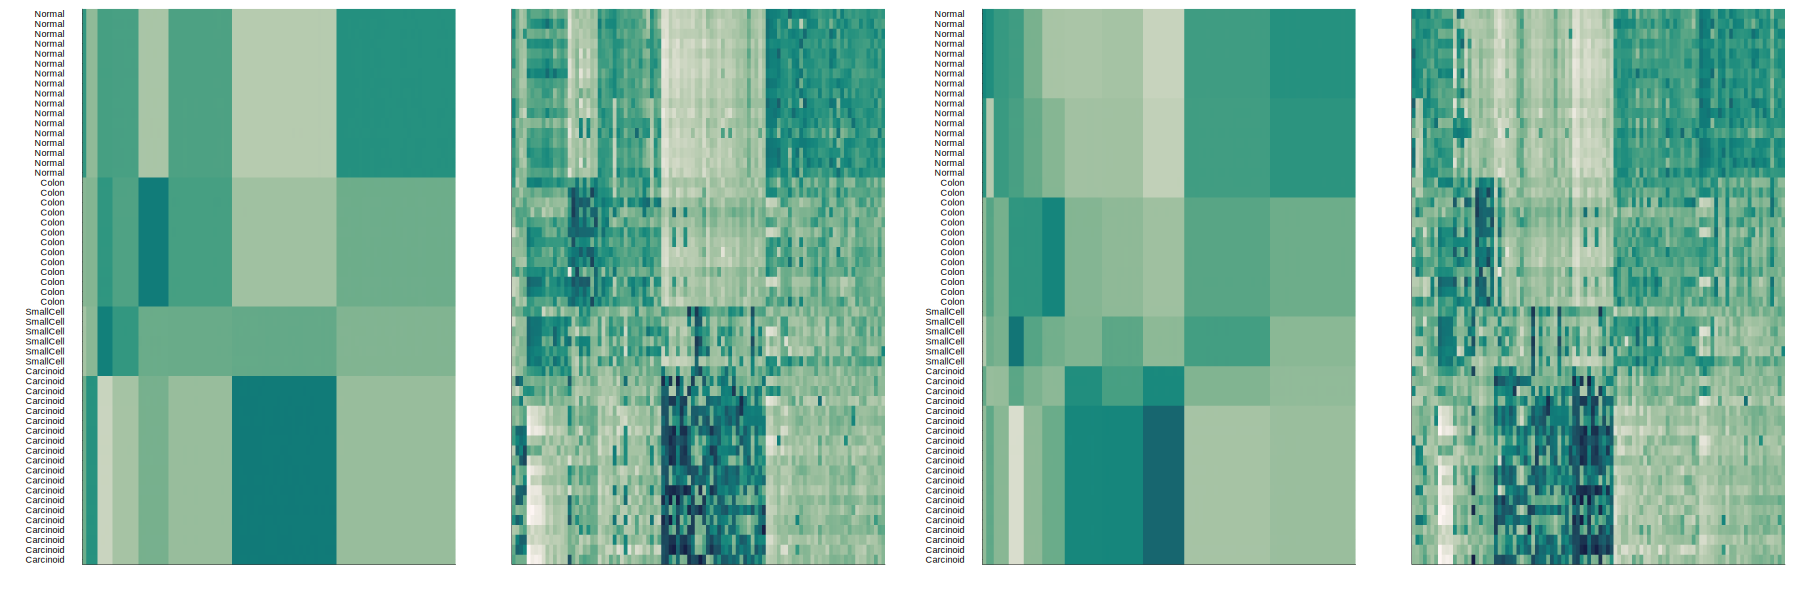

In [28]:
F

In [43]:
R"library(gdata);
index   = rownames(lung);
orig    = read.xls('/Users/yosikim/Downloads/DatasetA_12600gene.xls');
";
R"A = read.xls('/Users/yosikim/Downloads/SampleData.xls');"; @rget A;
R"probe_orig = orig$probe; probe = rownames(lung);"; @rget probe; @rget probe_orig;
geneindex = findin(probe_orig, probe); @rget orig;
carcinoid = [192;193;194;195;186;196;197;198;187;188;199;189;190;200;201;202;203;204;191;205];
normal    = 142:158;
smallcell = [159;161;162;160;163;164];
ind       = [carcinoid;normal;smallcell];


gdata: Unable to load perl libaries needed by read.xls()
gdata: to support 'XLSX' (Excel 2007+) files.

gdata: Run the function 'installXLSXsupport()'
gdata: to automatically download and install the perl
gdata: libaries needed to support Excel XLS and XLSX formats.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



In [97]:
genename = orig[:gene][findin(probe_orig,probe)];

In [92]:
unique(collect(genename[find(B1[:,5] .* B2[:,6])]))

5-element Array{String,1}:
 "glutamate receptor, ionotropic, AMPA 2"                                                                                                    
 "small inducible cytokine subfamily A (Cys-Cys), member 18, pulmonary and activation-regulated"                                             
 " Cluster Incl W60864:zd27g05.s1 Homo sapiens cDNA, 3 end /clone=IMAGE-341912 /clone_end=3'' /gb=W60864 /gi=1367661 /ug=Hs.9963 /len=541'' "
 "secreted phosphoprotein 1 (osteopontin, bone sialoprotein I, early T-lymphocyte activation 1)"                                             
 "LPS-induced TNF-alpha factor"                                                                                                              

In [113]:
for i = 1:8
    for j = 1:11
        inddd = find(B1[:,i] .* B2[:,j]);
        if (length(inddd) > 1) & (length(inddd) < 6)
            println(length(collect(genename[inddd])))
            println(unique(collect(genename[inddd])))
            println("####",i," ",j)
        end
    end
end

2
String["proteoglycan 1, secretory granule", " Cluster Incl AI932613:wo05c02.x1 Homo sapiens cDNA, 3 end /clone=IMAGE-2454434 /clone_end=3'' /gb=AI932613 /gi=5671350 /ug=Hs.62036 /len=570'' "]
####2 7
4
String[" Cluster Incl AI147237:qb36f02.x1 Homo sapiens cDNA, 3 end /clone=IMAGE-1698363 /clone_end=3'' /gb=AI147237 /gi=3674919 /ug=Hs.210732 /len=474'' ", " Cluster Incl S71043:Ig alpha 2=immunoglobulin A heavy chain allotype 2 {constant region, germ line} [human, peripheral blood neutrophils, Genomic, 1799 nt] /cds=(0,1022) /gb=S71043 /gi=546798 /ug=Hs.32225 /len=1047 ", "advanced glycosylation end product-specific receptor", "leukocyte immunoglobulin-like receptor, subfamily B (with TM and ITIM domains), member 1"]
####3 4
2
String["immunoglobulin lambda locus", "glypican 3"]
####5 5
5
String["glutamate receptor, ionotropic, AMPA 2", "small inducible cytokine subfamily A (Cys-Cys), member 18, pulmonary and activation-regulated", " Cluster Incl W60864:zd27g05.s1 Homo sapiens cDNA, 3 

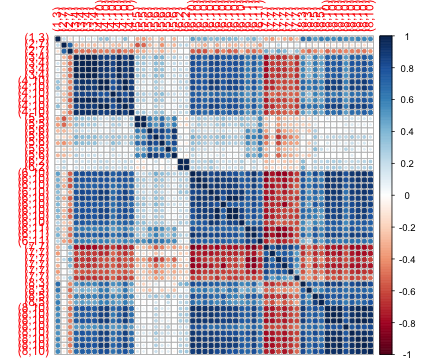

In [120]:
indd = [find(B1[:,1] .* B2[:,3]);
        find(B1[:,2] .* B2[:,7]);
        find(B1[:,3] .* B2[:,4]);
        find(B1[:,4] .* B2[:,10]);
        find(B1[:,5] .* B2[:,5]);
        find(B1[:,5] .* B2[:,6]);
        find(B1[:,6] .* B2[:,2]);
        find(B1[:,6] .* B2[:,10]);
        find(B1[:,6] .* B2[:,11]);
        find(B1[:,7] .* B2[:,7]);
        find(B1[:,8] .* B2[:,3]);
        find(B1[:,8] .* B2[:,5]);
        find(B1[:,8] .* B2[:,10])]
@rput indd; xx = out[:theta][indd,:]'; @rput xx;
R"x = t(lung)[,indd];
colnames(x) = c('(1,3)',rep('(2,7)',2),rep('(3,4)',4),rep('(4,10)',6),rep('(5,5)',2),rep('(5,6)',5),
                rep('(6,2)',2),rep('(6,10)',9),rep('(6,11)',3),rep('(7,7)',6),
                rep('(8,3)',2), rep('(8,5)',2),rep('(8,10)',8));
library(corrplot); corrplot(cor(x));
png('~/Desktop/p1.png', width=800,height=700);
corrplot(cor(x));
dev.off();";